In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, decimate
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks


# Assigned ranges for analysis
range1=("092022", "092212")
range2=("091122", "091312")
range3=("090302", "090452")


In [1]:
def get_range(ts_start: str, ts_end: str, dx=5.1065, dt=0.0016):
    files = glob.glob("../data/*.npy")
    files.sort()
    
    def extract_ts(path):
        fname = path.split("\\")[-1].split("/")[-1].split(".")[0]
        return datetime.datetime.strptime("2024-05-07 " + fname, "%Y-%m-%d %H%M%S")
    
    ts_start_dt = datetime.datetime.strptime("2024-05-07 " + ts_start, "%Y-%m-%d %H%M%S")
    ts_end_dt = datetime.datetime.strptime("2024-05-07 " + ts_end, "%Y-%m-%d %H%M%S")
    
    selected = []
    timestamps = []
    for f in files:
        ts = extract_ts(f)
        if ts_start_dt <= ts <= ts_end_dt:
            selected.append(f)
            timestamps.append(ts)
    
    if not selected:
        raise ValueError("No files found between the given timestamps.")
    
    arrays = [np.load(f) for f in selected]
    data = np.concatenate(arrays)
    
    index = pd.date_range(start=timestamps[0], periods=len(data), freq=f"{dt}s")
    columns = np.arange(data.shape[1]) * dx
    df = pd.DataFrame(data=data, index=index, columns=columns)
    
    return {"data": data, "df": df, "dt": dt, "dx": dx}

WZMACNIANIE SŁABYCH LINII – TYLKO BASELINE

Obliczam moving std (okno=25)...
Aplikuję bilateral filter (5, 25, 30)...


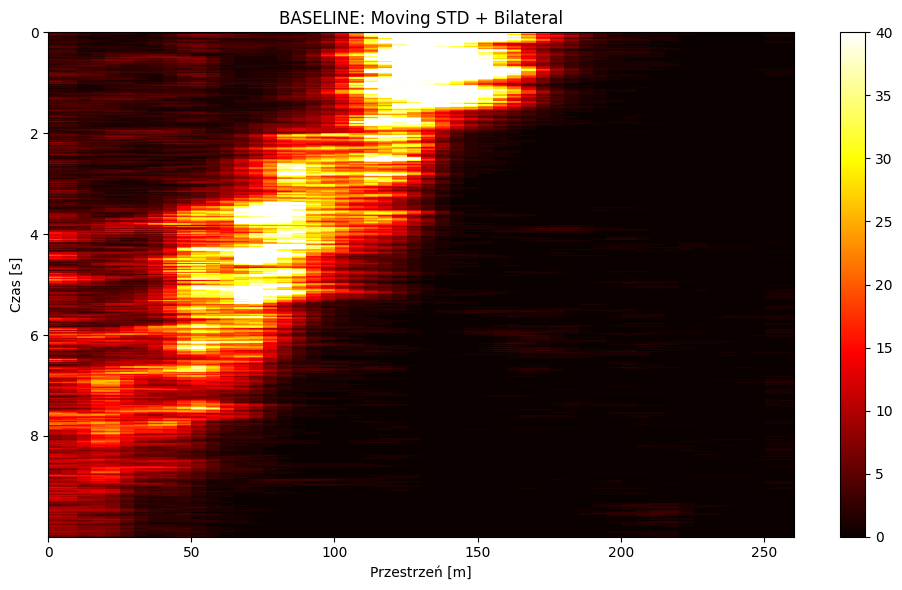

In [6]:
def uniform_filter_numpy(data, size):
    half = size // 2
    # replicate padding
    padded = np.pad(data, ((half, half), (0, 0)), mode='edge')
    
    # cumulative sum along time
    cumsum = np.cumsum(padded, axis=0)
    
    # okno przesuwne: suma z cumsum
    result = (cumsum[size:] - cumsum[:-size]) / size
    return result

def enhance_weak_lines(ts_start: str, ts_end: str, window_size=25):
    """
    ONLY BASELINE (moving std + bilateral)
    """
    pack = get_range(ts_start, ts_end)
    data = pack["data"]
    dt = pack["dt"]
    dx = pack["dx"]
    
    print("="*60)
    print("WZMACNIANIE SŁABYCH LINII – TYLKO BASELINE")
    print("="*60)
    
    import cv2
    from scipy.ndimage import uniform_filter
    from skimage import exposure, filters
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    
    time_axis = np.arange(data.shape[0]) * dt
    space_axis = np.arange(data.shape[1]) * dx
    
    # BASELINE: moving std
    print(f"\nObliczam moving std (okno={window_size})...")
    data_mean = uniform_filter_numpy(data, window_size)
    data_sq   = uniform_filter_numpy(data**2, window_size)
    base_std = np.sqrt(np.maximum(data_sq - data_mean**2, 0))
    
    # Bilateral
    print("Aplikuję bilateral filter (5, 25, 30)...")
    base_norm = ((base_std - np.min(base_std)) / (np.max(base_std) - np.min(base_std)) * 255).astype(np.uint8)
    base_bilateral = cv2.bilateralFilter(base_norm, d=5, sigmaColor=25, sigmaSpace=30).astype(np.float64)

    plt.figure(figsize=(10, 6))
    low, high = np.percentile(base_bilateral, [3, 97])
    
    plt.imshow(
        base_bilateral,
        aspect='auto',
        interpolation='none',
        norm=Normalize(vmin=low, vmax=high, clip=True),
        cmap='hot',
        extent=[0, space_axis[-1], time_axis[-1], 0]
    )
    
    plt.title("BASELINE: Moving STD + Bilateral")
    plt.ylabel("Czas [s]")
    plt.xlabel("Przestrzeń [m]")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    
    return {
        'baseline': base_bilateral,
        'dt': dt,
        'dx': dx
    }


# RUN
weak_lines = enhance_weak_lines(range3[0], range3[1], window_size=25)
